In [61]:
# quantum imports
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import RealAmplitudes
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import Session
from timeit import default_timer as timer
from qiskit_aer import AerSimulator

# from pylatexenc import *
from qiskit.visualization import plot_circuit_layout
import warnings
warnings.filterwarnings('ignore')

QiskitRuntimeService.save_account(channel="ibm_quantum", token="Your_API", overwrite=True)

In [62]:
# classical imports
import numpy as np
import time
import matplotlib.pyplot as plt
from itertools import combinations
import itertools
import random
import sys

In [63]:
def held_karp(dists):
    n = len(dists)

    # Maps each subset of the nodes to the cost to reach that subset, as well
    # as what node it passed before reaching this subset.
    # Node subsets are represented as set bits.
    C = {}

    # Set transition cost from initial state
    for k in range(1, n):
        C[(1 << k, k)] = (dists[0][k], 0)

    # Iterate subsets of increasing length and store intermediate results
    # in classic dynamic programming manner
    for subset_size in range(2, n):
        for subset in itertools.combinations(range(1, n), subset_size):
            # Set bits for all nodes in this subset
            bits = 0
            for bit in subset:
                bits |= 1 << bit

            # Find the lowest cost to get to this subset
            for k in subset:
                prev = bits & ~(1 << k)

                res = []
                for m in subset:
                    if m == 0 or m == k:
                        continue
                    res.append((C[(prev, m)][0] + dists[m][k], m))
                C[(bits, k)] = min(res)

    # We're interested in all bits but the least significant (the start state)
    bits = (2**n - 1) - 1

    # Calculate optimal cost
    res = []
    for k in range(1, n):
        res.append((C[(bits, k)][0] + dists[k][0], k))
    opt, parent = min(res)

    # Backtrack to find full path
    path = []
    for i in range(n - 1):
        path.append(parent)
        new_bits = bits & ~(1 << parent)
        _, parent = C[(bits, parent)]
        bits = new_bits

    # Add implicit start state
    path.append(0)

    return opt, list(reversed(path))

def generate_distances(n):
    dists = [[0] * n for i in range(n)]
    for i in range(n):
        for j in range(i+1, n):
            dists[i][j] = dists[j][i] = random.randint(1, n+1)
    return dists

def read_distances(filename):
    dists = []
    with open(filename, 'r') as f:
        for line in f:
            # Skip comments
            if line[0] == '#':
                continue
            dists.append(list(map(int, map(str.strip, line.split(',')))))
    return dists

def print_distance_matrix(dists):
    print("Distance Matrix:")
    for row in dists:
        print(' '.join([str(n).rjust(3, ' ') for n in row]))
    print('')

In [64]:
def calculate_path_cost(path, dists):
    """
    Calculate the total cost of a given TSP path.

    Parameters:
    path (list): The sequence of nodes in the path.
    dists (list of list): The distance matrix.

    Returns:
    int: The total cost of the path.
    """
    total_cost = 0
    n = len(path)
    
    # Calculate the cost of visiting each consecutive pair of nodes
    for i in range(n - 1):
        total_cost += dists[path[i]][path[i + 1]]
    
    # Add the cost of returning to the starting point
    total_cost += dists[path[-1]][path[0]]
    
    return total_cost

In [65]:
def quantum_held_karp(dists):
    n = len(dists)
    
    # Initialize Qiskit Runtime Service
    service = QiskitRuntimeService()
    
    # Use the backend 'ibm_rensselaer'
    backend = service.get_backend('ibm_rensselaer')
    
    # Create a quantum circuit for the TSP problem
    def create_quantum_circuit(n):
        circuit = QuantumCircuit(n)
        circuit.h(range(n))
        return circuit

    def tsp_cost_function(params, dists):
        qc = create_quantum_circuit(len(dists))
        ansatz = RealAmplitudes(len(dists),entanglement='linear', reps=1)
        qc.append(ansatz, range(len(dists)))
        qc.measure_all()

        
        # Assign parameters to the circuit
        bound_circuit = qc.assign_parameters({param: value for param, value in zip(ansatz.parameters, params)})


        # Transpile the circuit for the simulator or backend
        transpiled_circuit = transpile(bound_circuit, backend=AerSimulator(), optimization_level=3)
        
        simulator = AerSimulator()
        result = simulator.run(transpiled_circuit).result()
        counts = result.get_counts()

        cost = 0
        for bitstring, count in counts.items():
            route = [int(bit) for bit in bitstring]
            route_distance = sum(dists[route[i]][route[i + 1]] for i in range(len(route) - 1))
            route_distance += dists[route[-1]][route[0]]  # Completing the cycle
            cost += route_distance * count

        return cost / sum(counts.values())

    # Running the quantum circuit and calculating the minimum distance
    min_distance = float('inf')
    best_path = None
    min_runtime = float('inf')

    with Session(service=service, backend=backend):
        estimator = Estimator(backend)
        for _ in range(5):  # Run multiple times for better results
            start_time = time.time()
            params = np.random.rand(len(dists) * 2)
            distance = tsp_cost_function(params, dists)
            end_time = time.time()
            runtime = end_time - start_time
            
            best_path = params
            best_path = np.argsort(best_path[:n])
            distance2 = calculate_path_cost(best_path, dists)
            
            if distance2 < min_distance and runtime < min_runtime:
                min_distance = distance2
                best_path = params
                min_runtime = runtime

    # Backtracking the path from quantum circuit parameters
    best_path = np.argsort(best_path[:n])

    return min_distance, best_path.tolist(), min_runtime

In [66]:
def generate_tsp_hamiltonian(dis_mat):
    """Generates a Hamiltonian representing the TSP problem for a given number of nodes."""
    pauli_terms = []
    coefficients = []
    for i in range(len(dis_mat)):
        for j in range(i + 1, len(dis_mat[i])):
            weight = dis_mat[i][j]
            z_term = ['I'] * len(dis_mat)
            z_term[i] = 'Z'
            z_term[j] = 'Z'
            pauli_terms.append(''.join(z_term))
            coefficients.append(weight)
    
    return SparsePauliOp.from_list(list(zip(pauli_terms, coefficients)))

def quantum_held_karp2(dists):
    n = len(dists)
    hamiltonian = generate_tsp_hamiltonian(dists)
    
    # Initialize Qiskit Runtime Service
    service = QiskitRuntimeService()
    
    # Use the backend 'ibm_rensselaer'
    backend = service.backend('ibm_rensselaer')
    
    # Create a quantum circuit for the TSP problem
    def create_quantum_circuit2(n):
        circuit = QuantumCircuit(n)
        circuit.h(range(n))
        return circuit

    def tsp_cost_function2(params, dists):
        qc = create_quantum_circuit2(len(dists))
        ansatz = RealAmplitudes(len(dists),entanglement='linear', reps=1)
        qc.append(ansatz, range(len(dists)))
        qc.measure_all()

        
        # Assign parameters to the circuit
        bound_circuit = qc.assign_parameters({param: value for param, value in zip(ansatz.parameters, params)})


        # Transpile the circuit for the simulator or backend
        
        simulator = generate_preset_pass_manager(backend=backend, optimization_level=1)
        optimized_circuit = simulator.run(bound_circuit)
        observable = hamiltonian.apply_layout(layout=optimized_circuit.layout, num_qubits=127)
        theta = np.random.random(optimized_circuit.num_parameters) 
        
        start_time = timer()
        job = estimator.run([(optimized_circuit, observable, [theta])])
        end_time = timer()
        result = job.result()
        runtime = end_time - start_time
        
        r = result.values[0] if hasattr(result, 'values') else result
        
        return runtime, r

    # Running the quantum circuit and calculating the minimum distance
    min_distance = float('inf')
    best_path = None
    min_runtime = float('inf')

    with Session(service=service, backend=backend):
        estimator = Estimator(backend)
        for _ in range(5):  # Run multiple times for better results
            params = np.random.rand(len(dists) * 2)
            runtime, distance = tsp_cost_function2(params, dists)
            
            best_path = params
            best_path = np.argsort(best_path[:n])
            distance2 = calculate_path_cost(best_path, dists)
                        
            if distance2 < min_distance and runtime < min_runtime:
                min_distance = distance2
                best_path = params
                min_runtime = runtime

    # Backtracking the path from quantum circuit parameters
    best_path = np.argsort(best_path[:n])

    return min_distance, best_path.tolist(), min_runtime

In [67]:
h = open("check_results.txt", 'w')
h.write("")
h.close()

2: TSP DONE
2: Simulator DONE
2: IBM System one DONE

3: TSP DONE
3: Simulator DONE
3: IBM System one DONE

4: TSP DONE
4: Simulator DONE
4: IBM System one DONE

5: TSP DONE
5: Simulator DONE
5: IBM System one DONE

6: TSP DONE
6: Simulator DONE
6: IBM System one DONE

7: TSP DONE
7: Simulator DONE
7: IBM System one DONE

8: TSP DONE
8: Simulator DONE
8: IBM System one DONE

9: TSP DONE
9: Simulator DONE
9: IBM System one DONE

10: TSP DONE
10: Simulator DONE
10: IBM System one DONE

11: TSP DONE
11: Simulator DONE
11: IBM System one DONE

12: TSP DONE
12: Simulator DONE
12: IBM System one DONE

13: TSP DONE
13: Simulator DONE
13: IBM System one DONE

14: TSP DONE
14: Simulator DONE
14: IBM System one DONE

15: TSP DONE
15: Simulator DONE
15: IBM System one DONE

16: TSP DONE
16: Simulator DONE
16: IBM System one DONE

17: TSP DONE
17: Simulator DONE
17: IBM System one DONE

18: TSP DONE
18: Simulator DONE
18: IBM System one DONE

19: TSP DONE
19: Simulator DONE
19: IBM System one DONE

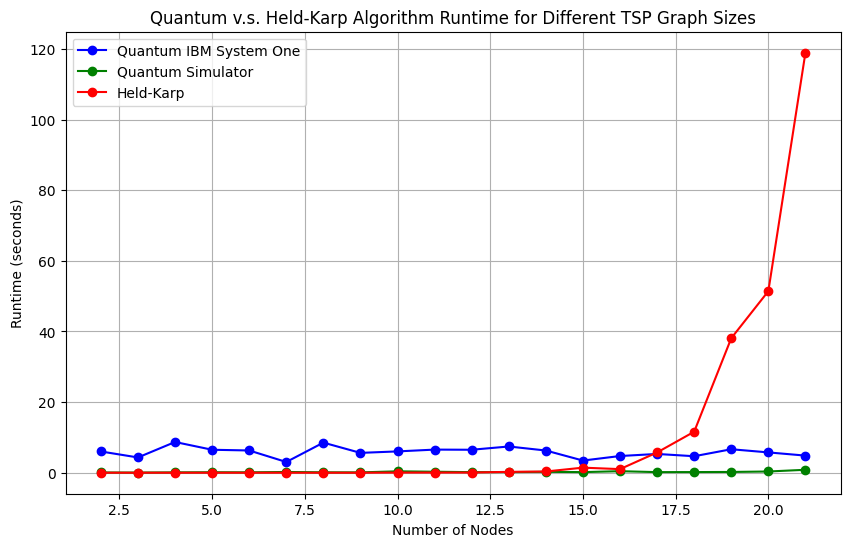

In [68]:
# testing
# Run the quantum TSP for different graph sizes
# Initialize the Qiskit Runtime Service and specify the backend
max = 22
node_sizes = range(2, max)

runtimesC = []
runtimesQ = []
runtimesQ2 = []
for n in node_sizes:
    h = open("check_results.txt", 'a')
    # Generate distance matrix 
    dists = generate_distances(n)
    
    # Measure runtime of Held-Karp algorithm
    start_time = time.time()
    min_dist, pathC = held_karp(dists)
    end_time = time.time()
    costC = calculate_path_cost(pathC, dists)
    # Print results
    h.write(f"Nodes: {n}\n")
    h.write("Classical\n")
    h.write(f"\tPath = {pathC} and the min distance = {costC}\n")

    # Print runtime
    runtime = end_time - start_time
    h.write(f"\tRuntime: {runtime:.6f} seconds\n")
    runtimesC.append(runtime)
    print(f"{n}: TSP DONE")
    
    min_distance, pathQ, q_runtime= quantum_held_karp(dists)
    costQ = calculate_path_cost(pathQ, dists)
    h.write("Quantum Simulator")
    h.write(f"\tPath taken: {pathQ} and the min distance = {costQ}\n")
    h.write(f"\tExecution time: {q_runtime} seconds\n")
    runtimesQ.append(q_runtime)
    print(f"{n}: Simulator DONE")
    
    min_distance2, pathQ2, q_runtime2= quantum_held_karp2(dists)
    costQ2 = calculate_path_cost(pathQ2, dists)
    h.write("Quantum IBM System One")
    h.write(f"\tPath taken: {pathQ2} and the min distance = {costQ2}\n")
    h.write(f"\tExecution time: {q_runtime2} seconds\n\n")
    runtimesQ2.append(q_runtime2)
    print(f"{n}: IBM System one DONE\n")

    h.close()

for i in range(len(node_sizes)):
    print(f"Nodes {node_sizes[i]}: Held-Karp Runtime was {(runtimesC[i]):.4f} seconds and Quantum Simulator Runtime was {runtimesQ[i]:.4f} seconds and Quantum IBM System One Runtime was {runtimesQ2[i]:.4f} seconds")

# Plot the runtimes
plt.figure(figsize=(10, 6))
plt.plot(node_sizes, runtimesQ2, marker='o', linestyle='-', color='b', label='Quantum IBM System One')
plt.plot(node_sizes, runtimesQ, marker='o', linestyle='-', color='g', label='Quantum Simulator')
plt.plot(node_sizes, runtimesC, marker='o', linestyle='-', color='r', label='Held-Karp')

plt.title('Quantum v.s. Held-Karp Algorithm Runtime for Different TSP Graph Sizes')
plt.xlabel('Number of Nodes')
plt.ylabel('Runtime (seconds)')

plt.legend()

plt.grid(True)
plt.show()